# Exercise of WIC
Intelligent Embedded Systems Lab, University of Freiburg

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Contact: Lena Uhlenberg lena.uhlenberg@informatik.uni-freiburg.de

March, 2023


## Introduction
Implementing machine learning methods helps to understand corresponding algorithms better. However, it usually requires iterations of careful test before the implementation gets into a bug-free version. In practice, people prefer to solve machine learning challenges using existing machine learning libraries, such as the **scikit-learn** library, which has been tested on various datasets. In this exercise, we will use the scikit-learn library to perform daily activity recognition through a three-activity classification task. We will further look into basic machine learning concepts such as feature selection, over-fitting, under-fitting, and cross-validation.

## Learning objectives
1. Understand the importance of feature selection and selection principles.
2. Understand the concept of over-fitting and under-fitting.
3. Understand the purpose of cross-validation.
4. Create machine learning pipelines.
5. Analyze classification performance.


## Procedure
1. Follow the notebook and complete the code snippets where required.
2. Answer the questions at the end of the notebook.
3. Submit the notebook after finishing the previous steps.


## Data

For this exercise, we use an excerpt of the dataset collected for the paper:
*Florian Wahl, Martin Freund, Oliver Amft, "WISEglass: Smart eyeglasses recognising context", EAI Endorsed Transactions on Pervasive Health and Technology, eudl.eu, 2015*. PDF at the bottom of the page: https://www.cdh.med.fau.de/publications/?id=FHX48BI6.


In [1]:
import sklearn
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneGroupOut
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load data
all_df = pd.read_hdf('data/data_E3.h5', 'data')

# Add category info to data
label_category_dict = dict([(1, 1), (15, 1), (25, 1), (6, 2), (7, 2), (10, 3), (17, 3), (18, 3)])
label_category_str_dict = dict([(1, 'Eating'), (15, 'Eating'), (25, 'Eating'), (6, 'Walking'), (7, 'Walking'), (10, 'Sedentary'), (17, 'Sedentary'), (18, 'Sedentary')])
all_df['label_category'] = all_df.label.map(label_category_dict)
all_df['label_category_str'] = all_df.label.map(label_category_str_dict)

# Print data
all_df

,maccelX_mean,maccelY_mean,maccelZ_mean,mgyroX_mean,mgyroY_mean,mgyroZ_mean,maccelNorm_mean,maccelX_var,maccelY_var,maccelZ_var,...,maccelY_energy,maccelZ_energy,mgyroX_energy,mgyroY_energy,mgyroZ_energy,maccelNorm_energy,label,participant,label_category,label_category_str
0,-13133.378667,-7415.320000,-395.850667,5.024667,6.200000,-15.978000,15410.648624,1.516028e+06,5.755263e+06,2.667956e+06,...,6.073840e+07,2.822876e+06,16320.788667,12938.778667,29583.951333,2.375619e+08,1.0,2,1,Eating
1,-13007.874667,-7682.157333,-358.869333,7.191333,4.004667,-8.756667,15412.061591,1.505408e+06,5.090313e+06,2.664039e+06,...,6.410246e+07,2.791050e+06,16177.471333,13034.294000,24649.263333,2.376027e+08,1.0,2,1,Eating
2,-12906.002667,-7826.821333,-349.053333,3.112667,1.202667,-9.877333,15414.941325,1.636886e+06,5.441185e+06,2.667817e+06,...,6.669669e+07,2.787877e+06,15644.151333,12381.952000,24560.297333,2.376853e+08,1.0,2,1,Eating
3,-12816.824000,-7968.296000,-348.152000,7.327333,3.408000,-3.300667,15422.191246,1.699774e+06,5.641997e+06,2.703788e+06,...,6.913198e+07,2.823195e+06,21359.918000,13946.748000,27313.195333,2.379248e+08,1.0,2,1,Eating
4,-12855.394667,-7832.786667,-380.584000,13.038667,8.230000,3.961333,15419.660302,1.837918e+06,6.592879e+06,2.674607e+06,...,6.794103e+07,2.817668e+06,28843.077333,16063.036667,30863.672000,2.378566e+08,1.0,2,1,Eating
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42736,-4475.682667,-10913.600000,-848.034667,32.270000,-3.014667,16.198667,15875.238871,5.150524e+07,5.876971e+07,2.277925e+06,...,1.778372e+08,2.995569e+06,38318.616667,10365.056000,99706.532000,2.523354e+08,18.0,9,3,Sedentary
42737,-4954.970667,-10521.248000,-794.304000,28.883333,0.615333,5.826667,15862.542711,5.415325e+07,5.961817e+07,2.367750e+06,...,1.702751e+08,2.997090e+06,39287.370000,9941.262000,104946.830667,2.519411e+08,18.0,9,3,Sedentary
42738,-5367.013333,-10284.162667,-726.389333,25.832000,-4.498667,3.422667,15843.942226,5.515170e+07,5.873720e+07,2.452708e+06,...,1.644620e+08,2.978714e+06,39757.109333,10821.868000,105873.258667,2.513605e+08,18.0,9,3,Sedentary
42739,-5757.402667,-10097.968000,-627.642667,25.146667,-5.733333,2.374667,15827.625221,5.517717e+07,5.763974e+07,2.598419e+06,...,1.595703e+08,2.990622e+06,39806.833333,10980.894667,106266.966667,2.508490e+08,18.0,9,3,Sedentary


## Data standardization
Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

For instance, many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machine) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. An example of data standardization is below:       

In [2]:
from sklearn import preprocessing
X_train = np.array([[ 1., -1.,  2.],
                    [ 2.,  0.,  0.],
                    [ 0.,  1., -1.]])
X_scaled = preprocessing.scale(X_train)

X_scaled  

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

## Feature extraction using PCA
Principal Component Analysis (PCA) is one of the most popular dimensionality reduction methods which transforms the data by projecting it to a set of orthogonal axes. It works by finding the eigenvectors and eigenvalues of the covariance matrix of the dataset. The Eigenvectors are called as the “Principal Components” of the dataset.
More details of PCA are described in this document: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

For the PCA we will be using sklearn.preprocessing.StandardScaler library: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html. It standardize the features by removing the mean and scaling to unit variance. It arranges the data in the normal distribution.

In [3]:
clean_df = (all_df.dropna(axis=1)).iloc[:,:-4]# drop all column with Nan entries and the columns containing strings (last 4 columns)

X=clean_df.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data


In [4]:
#An important attribute as part of the PCA is n_components which tells the number of components to keep after applying PCA.
#If n_components is not set all components are kept

num_components = 3 #'Specify and play around here' # specify the number of components 
pca = PCA(num_components)
# or specify e.g. n_components = 0.9 parameter. PCA will select the number of components such 
#that the amount of variance that needs to be explained is greater than the percentage specified by n_components 

pca = PCA(n_components = num_components)

X_pca = pca.fit(X_std)

pd.DataFrame(pca.components_, columns = clean_df.columns)

,maccelX_mean,maccelY_mean,maccelZ_mean,mgyroX_mean,mgyroY_mean,mgyroZ_mean,maccelNorm_mean,maccelX_var,maccelY_var,maccelZ_var,...,mgyroY_rms,mgyroZ_rms,maccelNorm_rms,maccelX_energy,maccelY_energy,maccelZ_energy,mgyroX_energy,mgyroY_energy,mgyroZ_energy,maccelNorm_energy
0,-0.043784,0.062026,0.021137,0.001730,0.001976,0.008929,0.034900,0.087895,0.062479,0.038997,...,0.109498,0.097011,0.087111,0.073320,-0.046592,-0.016269,0.067522,0.108233,0.091774,0.086843
1,0.199581,-0.168223,-0.074790,0.001061,-0.006685,0.010620,0.183271,0.107529,-0.034712,0.024875,...,-0.020241,-0.050625,0.125803,-0.140423,0.187928,0.090031,-0.076948,0.015270,-0.035780,0.123583
2,-0.129090,0.109829,-0.005002,0.003463,0.013854,0.026432,-0.099746,0.116080,-0.109758,-0.111940,...,-0.084031,-0.117830,0.102894,0.154215,-0.126860,-0.037121,-0.113479,-0.029547,-0.099253,0.106751


In [6]:
n_pcs= pca.n_components_ # get number of component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)] # get the index of the most important feature on EACH component
initial_feature_names = clean_df.columns
# get the most important feature names
most_important_features = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_features

['mgyroZ_diff_diff_possum', 'maccelX_mean', 'maccelY_min']

## Implement a pattern classification pipeline
A scikit-learn pipeline integrates a number of scikit-learn functions, e.g. dealing with missing data, scaling features, selecting features, and building classifiers. 
More details of pipeline are described in this document: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html.

Below are some basic methods of populating the pipeline, especially the RobustScaler is used to standardize the data. In theory, the standardizer should compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results, and this is exactly what the RobustScaler does.

-  Imputer: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html
-  RobustScaler: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
-  GaussianNB: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html 

Tightly following the pipeline, a cross-validation strategy needs to be chosen. We use k-fold cross-validation (k equals the participant number) and leave out the samples of one participant in each fold. This strategy is called **Leave One Participant Out (LOPO)**. By applying LOPO, data usage is maximized.

Please complete the following tasks and see what combination yields the best performance:
1. Complete and run the example pipeline, inspect the result.
2. Try a few different combinations (feature sets, classifiers, parameters) to populate the pipeline and compare the performance.



In [7]:
# Features you extracted from PCA
X = all_df[most_important_features]# most important features
y = all_df['label_category']
participants = all_df['participant']

In [8]:
# First pipeline: Decision tree
pipe = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler(), DecisionTreeClassifier())
cv = LeaveOneGroupOut() # i.e. Leave-One-Participant-Out
dt_scores = cross_val_score(pipe, X, y, cv=cv, groups=participants)
dt_scores = pd.DataFrame(dt_scores, columns=['Score'])
dt_scores['Participant'] = participants
dt_scores['Classifier'] = 'Decision Tree'

In [9]:
# Second pipeline: GaussianNB
pipe = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler(), GaussianNB())
cv = LeaveOneGroupOut() #'PLEASE CODE HERE'# i.e. Leave-One-Participant-Out
gnb_scores = cross_val_score(pipe, X, y, cv=cv, groups=participants) #'PLEASE CODE HERE'# calculate score
gnb_scores = pd.DataFrame(gnb_scores, columns=['Score'])
gnb_scores['Participant'] = participants
gnb_scores['Classifier'] = 'GaussianNB'

In [10]:
# Implement a thirs pipeline: e.g. KNearestNeighbour, RandomForest, ADAboost
# 'PLEASE CODE HERE'
pipe = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler(), RandomForestClassifier())
cv = LeaveOneGroupOut() #'PLEASE CODE HERE'# i.e. Leave-One-Participant-Out
rf_scores = cross_val_score(pipe, X, y, cv=cv, groups=participants) #'PLEASE CODE HERE'# calculate score
rf_scores = pd.DataFrame(rf_scores, columns=['Score'])
rf_scores['Participant'] = participants
rf_scores['Classifier'] = 'RandomForest'

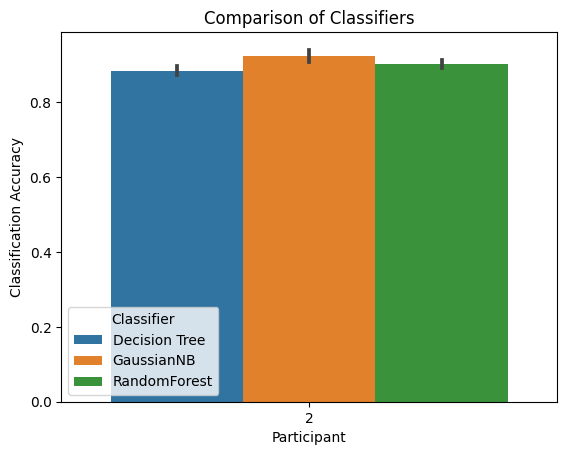

In [11]:
# Combine results of 2 pipelines and plot classification accuracy as bar chart
# Combine results of both pipelines
all_scores_df = pd.concat([dt_scores, gnb_scores, rf_scores])
# sns.barplot='PLEASE CODE HERE'
sns.barplot(data=all_scores_df, x='Participant', y='Score', hue='Classifier')
plt.xlabel('Participant')
plt.ylabel('Classification Accuracy')
plt.title('Comparison of Classifiers')
plt.show()

## Task 4: Error analysis
Run the code below and investigate the classifier confusion matrix.
What information can the confusion matrix offer? Try to improve the classification performance using the confusion matrix as the decision criterion.

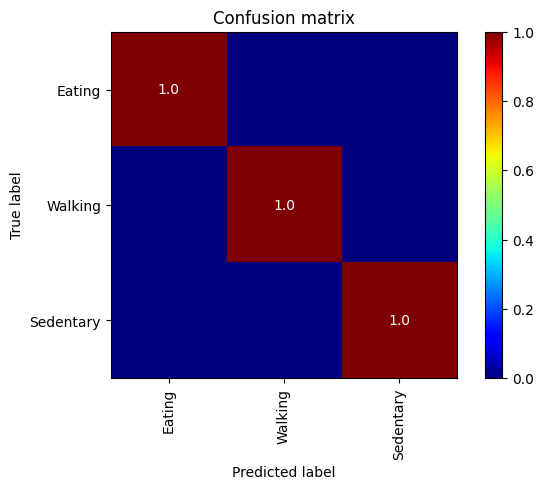

In [12]:
# Confusion matrix plot 
def plot_confusion_matrix(confusion_matrix, class_names, title='Confusion matrix', cmap=plt.cm.jet, annotate_threshold=0.1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    cax = ax.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for col in range(confusion_matrix.shape[1]):
        for row in range(confusion_matrix.shape[0]):
            if round(confusion_matrix[row, col], 1) >= annotate_threshold:
                ax.text(col, row, str(round(confusion_matrix[row, col], 1)), va='center', ha='center', color='white')
    return fig

# Make a prediction from your pipeline
pipe.fit(X, y)
dt_pred = pipe.predict(X) #'PLEASE CODE HERE'

# Create a confusion matrix plot
f = plot_confusion_matrix(metrics.confusion_matrix(y, dt_pred), ['Eating', 'Walking', 'Sedentary'])



## Questions

#### 1. What are criterions for selecting features? 
Answer: Relevance to the target variable, correlation with other features, informativeness, and computational efficiency.

#### 2. What is cross-validation and what is the purpose of performing cross-validation? 
Answer: Cross-validation is a technique used to assess the performance and generalization ability of a machine learning model. It involves dividing the dataset into multiple subsets, training the model on some subsets, and evaluating it on the remaining subsets. The purpose is to estimate how the model will perform on unseen data and to tune hyperparameters without overfitting.

#### 3. Please explain the procedure steps of LOPO cross-validation.
Answer: LOPO (Leave-One-Participant-Out) cross-validation is a technique used in scenarios where participants or subjects play a significant role in the data. The steps are as follows:
1. Iterate through each participant in the dataset.
2. Exclude the data of the current participant from the training set.
3. Train the model on the remaining participants' data.
4. Evaluate the model's performance on the excluded participant's data.
5. Repeat steps 2-4 for each participant.
6. Calculate the average performance across all iterations.

#### 4. What are under-fitting and over-fitting in machine learning?
Answer: 
- Under-fitting: Under-fitting occurs when a machine learning model is too simple to capture the underlying patterns in the data, resulting in poor performance on both the training and testing datasets. It typically arises when the model is not complex enough to represent the data adequately.
- Over-fitting: Over-fitting happens when a machine learning model performs extremely well on the training data but fails to generalize well to new, unseen data. It occurs when the model is too complex or when it has memorized noise or outliers in the training dataset, leading to poor performance on the testing dataset.







## Submission
Make sure all coding tasks are completed, code blocks are executed, and all questions are answered.<br>
Enter your name(s) and matriculation number(s) here:<br>
**Name(s)**:                            <br>
**Matriculation number(s)**:                              <br>